In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.7.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetD_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetD_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [7]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = '/glade/campaign/univ/upsu0032/Hyperion_ET/composites/'
    Compo_File = xr.open_dataset(Diri + File)
    return (Compo_File)

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
Control_B_Compo_nc = Composite_File('composite_h3_CORI.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
Control_C_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP45_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
RCP45_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP85_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
RCP85_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.004.nc')

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon)
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, \
    "Time": Snap_Time, "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
#    print (Year_Orig)
    Orig_Time = New_Time.replace(year=Year_Orig)
    return (Orig_Time)

In [20]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900,1930,1960,2000,2031,2062,2100,2131,2162,2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [21]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    Code_List = DF_Storm["Code"]
    Name_List = DF_Storm["Name"]
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    for i in range(len(New_Time)):
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
# Find Possible Storms that Occur at the Same Time
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
# If No Storm Found:
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
# Storms Found:
        else:
            Dist_Min = [7428,-728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
# Find Storm Closest to Storm Center
                if Dist < Dist_Min[0]:
# At Most 300km of Error in Location Permitted
                    if Dist < 300:
                        Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
                    else:
                        Dist_Min = [Dist, -728]
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo_Init = pandas.DataFrame({"Code": Code_List, "Name": Name_List, \
    "Compo Index": Compo_Indexes, "Time": New_Time, \
    "Lon": Lon, "Lat": Lat, "SLP": SLP, "Storm Phase": Storm_Phase})
# Remove Datapoints With Missing Compo Index
    DF_Storm_Compo = DF_Storm_Compo_Init[DF_Storm_Compo_Init["Compo Index"] >= 0].reset_index()
    DF_Storm_Compo = DF_Storm_Compo.drop("index", axis=1)
    return (DF_Storm_Compo)

In [22]:
def Windspeed_850hPa(Compo_nc, Compo_Index):
    U850 = numpy.array(Compo_nc.snap_U850[int(Compo_Index)])
    V850 = numpy.array(Compo_nc.snap_V850[int(Compo_Index)])
    Snap_850 = numpy.sqrt(U850 **2 + V850 **2)
    return (Snap_850)

In [23]:
# Find Precip Rate From Compo File
def Precip_Rate(Compo_nc, Compo_Index):
    Precip_ms = numpy.array(Compo_nc.snap_PRECT[int(Compo_Index)])
    Precip_mmhr = Precip_ms * 3600 * 1000
    return (Precip_mmhr)

In [24]:
# Find Precipitable Water From Compo File
def Precip_Water(Compo_nc, Compo_Index):
    Precipitable_Water = numpy.array(Compo_nc.snap_TMQ[int(Compo_Index)])
    return (Precipitable_Water)

In [25]:
# Find 850hPa Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
    SLP = DF_Storm_Compo["SLP"]
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((6,len(Compo_Index)))
    Wind_Field_Info[0] = SLP
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Windspeed Snap From Compo_nc
        Snap_850 = Windspeed_850hPa(Compo_nc, Compo_Index[k])
# Find Maximum 850hPa Windspeed
        Windspeed_850 = numpy.max(Snap_850)
        Wind_Field_Info[1][k] = Windspeed_850
# Count Number of Data Points With Windspeed Above 13,18,25,33m/s
        Snap_Sort = numpy.sort(Snap_850.ravel())
        Count_13 = len(Snap_Sort[Snap_Sort >= 13])
        Count_18 = len(Snap_Sort[Snap_Sort >= 18])
        Count_25 = len(Snap_Sort[Snap_Sort >= 25])
        Count_33 = len(Snap_Sort[Snap_Sort >= 33])
        Wind_Field_Info[2][k] = Count_13
        Wind_Field_Info[3][k] = Count_18
        Wind_Field_Info[4][k] = Count_25
        Wind_Field_Info[5][k] = Count_33
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo["850hPa Winds"] = Wind_Field_Info[1]
    DF_Storm_Compo["13m/s"] = Wind_Field_Info[2]
    DF_Storm_Compo["18m/s"] = Wind_Field_Info[3]
    DF_Storm_Compo["25m/s"] = Wind_Field_Info[4]
    DF_Storm_Compo["33m/s"] = Wind_Field_Info[5]
    return (DF_Storm_Compo)

In [26]:
# Find Max Precip and Total Precip Over Area
def Precip_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
#
# Create Array to Store Data
    Precip_Field_Info = numpy.zeros((7,len(Compo_Index)))
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find Precip Snap From Compo_nc
        Snap_Precip = Precip_Rate(Compo_nc, Compo_Index[k])
# Find Maximum Precip Rate
        Max_Precip = numpy.max(Snap_Precip)
        Precip_Field_Info[0][k] = Max_Precip
# Find Total Areal Precip
        Snap_Sort = numpy.sort(Snap_Precip.ravel())
        Areal_Precip_Total = numpy.sum(Snap_Sort)
        Precip_Field_Info[1][k] = Areal_Precip_Total
# Count Number of Data Points With Precip Rate Above 1, 5, 10mm/hr
        Count_1 = len(Snap_Sort[Snap_Sort >= 1])
        Count_5 = len(Snap_Sort[Snap_Sort >= 5])
        Count_10 = len(Snap_Sort[Snap_Sort >= 10])
        Precip_Field_Info[2][k] = Count_1
        Precip_Field_Info[3][k] = Count_5
        Precip_Field_Info[4][k] = Count_10
#
# Find Precipitable Water Snap From Compo_nc
        Snap_Precip_Water = Precip_Water(Compo_nc, Compo_Index[k])
# Find Maximum Precipitable Water
        Max_Precip_Water = numpy.max(Snap_Precip_Water)
        Precip_Field_Info[5][k] = Max_Precip_Water
# Find Areal Precipitable Water Total
        Precip_Water_Total = numpy.sum(Snap_Precip_Water.ravel())
        Precip_Field_Info[6][k] = Precip_Water_Total
# 
# Add Precip Field Info Into DF Storm Compo
    DF_Storm_Compo["Max Precip Rate"] = Precip_Field_Info[0]
    DF_Storm_Compo["Total Areal Precip"] = Precip_Field_Info[1]
    DF_Storm_Compo["1mm/hr"] = Precip_Field_Info[2]
    DF_Storm_Compo["5mm/hr"] = Precip_Field_Info[3]
    DF_Storm_Compo["10mm/hr"] = Precip_Field_Info[4]
    DF_Storm_Compo["Max Precip Water"] = Precip_Field_Info[5]
    DF_Storm_Compo["Total Precip Water"] = Precip_Field_Info[6]
    return (DF_Storm_Compo)

In [27]:
# Create New Data DF
def DF_Data_Compo(Data_DF, ET_DF, Compo_DF, Compo_nc_A, Compo_nc_B, Compo_nc_C):
    Code_List = ET_DF["Code"]
    ABC_List = ET_DF["ABC"]
# Loop Over Each Storm in Dataset
    for n in range(len(Code_List)):
        DF_Storm_Compo = Find_Composite_Data(Code_List[n], Data_DF, Compo_DF)
# Find Which Compo nc To Use
        if ABC_List[n] == "A":
            Compo_nc = Compo_nc_A
        elif ABC_List[n] == "B":
            Compo_nc = Compo_nc_B
        elif ABC_List[n] == "C":
            Compo_nc = Compo_nc_C
# Apply Functions For Finding Wind Field and Precip Field
        DF_Storm_Compo = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
        DF_Storm_Compo = Precip_Field_Find(DF_Storm_Compo, Compo_nc)
# Only Keep Storms With Complete ET Data
        if len(DF_Storm_Compo) > 0:
            if DF_Storm_Compo["Storm Phase"][len(DF_Storm_Compo)-1] == "Extratropical":
# Combine DF Storm Compos
                try:
                    Data_Compo = pandas.concat([Data_Compo, DF_Storm_Compo])
                except:
                    Data_Compo = DF_Storm_Compo.copy()
    Data_Compo_Final = Data_Compo.reset_index().drop("index", axis=1)
    return (Data_Compo_Final)

In [28]:
# Create New ET DF
def DF_ET_Compo(Data_Compo, ET_DF, Compo_DF, Compo_nc_A, Compo_nc_B, Compo_nc_C):
    Code_List = ET_DF["Code"]
# Loop Over Each Storm in Dataset
    for n in range(len(Code_List)):
        ET_Storm = Find_Storm(ET_DF, Code_List[n])
        DF_Storm_Compo = Find_Storm(Data_Compo, Code_List[n])
# Find ET Begin and ET Complete Time
        Trop_Peak_Time = ET_Storm["Trop Peak Time"][0]
        Begin_Time = ET_Storm["ET Begin Time"][0]
        Compl_Time = ET_Storm["ET Complete Time"][0]
        DF_Trop_Peak = DF_Storm_Compo[DF_Storm_Compo["Time"] == Trop_Peak_Time].reset_index()
        DF_Begin = DF_Storm_Compo[DF_Storm_Compo["Time"] == Begin_Time].reset_index()
        DF_Compl = DF_Storm_Compo[DF_Storm_Compo["Time"] == Compl_Time].reset_index()
# Only Keep Storms With Complete ET Data
        if len(DF_Storm_Compo) > 0 and len(DF_Trop_Peak) and len(DF_Begin) > 0 and len(DF_Compl) > 0:
# Combine ET Storm Compos
            ET_Storm_Compo = Find_ET_Compo(Code_List[n], ET_Storm, DF_Trop_Peak, DF_Begin, DF_Compl)
            try:
                ET_Compo = pandas.concat([ET_Compo, ET_Storm_Compo])
            except:
                ET_Compo = ET_Storm_Compo.copy()
        else:
            print (Code_List[n], len(DF_Trop_Peak), len(DF_Begin), len(DF_Compl))
    ET_Compo_Final = ET_Compo.reset_index().drop("index", axis=1)
    return (ET_Compo_Final)

In [29]:
def Find_ET_Compo(Code, ET_Storm, DF_Trop_Peak, DF_Begin, DF_Compl):
    ET_Storm_Compo = ET_Storm[["Code", "Name", "Trop Peak Time", "ET Begin Time", "ET Complete Time", \
    "Trop Peak SLP", "ET Begin SLP", "ET Complete SLP"]].copy()
    Vars = ["850hPa Winds", "13m/s", "18m/s", "25m/s", "33m/s", \
    "1mm/hr", "5mm/hr", "10mm/hr", "Max Precip Rate", "Max Precip Water", "Total Precip Water"]
    for m in range(len(Vars)):
        Var = Vars[m]
        Trop_Peak_Var = str("Trop Peak " + Var)
        Begin_Var = str("ET Begin " + Var)
        Compl_Var = str("ET Complete " + Var)
        ET_Storm_Compo[Trop_Peak_Var] = DF_Trop_Peak[Var][0]
        ET_Storm_Compo[Begin_Var] = DF_Begin[Var][0]
        ET_Storm_Compo[Compl_Var] = DF_Compl[Var][0]
    return (ET_Storm_Compo)

In [30]:
Control_Data_Compo = DF_Data_Compo(Control_Data, Control_ET, Control_Compo, \
Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [31]:
Control_ET_Compo = DF_ET_Compo(Control_Data_Compo, Control_ET, Control_Compo, \
Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [32]:
RCP45_Data_Compo = DF_Data_Compo(RCP45_Data, RCP45_ET, RCP45_Compo, \
RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [33]:
RCP45_ET_Compo = DF_ET_Compo(RCP45_Data_Compo, RCP45_ET, RCP45_Compo, \
RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [34]:
RCP85_Data_Compo = DF_Data_Compo(RCP85_Data, RCP85_ET, RCP85_Compo, \
RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [35]:
RCP85_ET_Compo = DF_ET_Compo(RCP85_Data_Compo, RCP85_ET, RCP85_Compo, \
RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [36]:
# Define Bins
Lat_Bins = Create_Bins(10,60,5)
Lon_Bins = Create_Bins(-100,0,10)
SLP_Bins = Create_Bins(900,1010,10)

In [37]:
# Create Function to Plot ET Histograms
def ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Rela, Orient, Bins, \
    Dens_Min, Dens_Max, Dens_Width, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,8))
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Plot ET Initiation
    Axis = Fig.add_subplot(1,2,1)
    Var1 = "ET Begin " + Var
    pyplot.hist([Control_ET[Var1], RCP45_ET[Var1], RCP85_ET[Var1]], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Histo_Formatting(Var, Var_Label, Rela, Orient, Bins, Dens_Min, Dens_Max, Dens_Width, "ET Initiation ")
#
# Plot ET Completion
    Axis = Fig.add_subplot(1,2,2)
    Var2 = "ET Complete " + Var
    pyplot.hist([Control_ET[Var2], RCP45_ET[Var2], RCP85_ET[Var2]], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Histo_Formatting(Var, Var_Label, Rela, Orient, Bins, Dens_Min, Dens_Max, Dens_Width, "ET Completion ")
#
# Legend
    if Orient == 'horizontal':
        pyplot.legend(loc=4, fontsize=15)
    else:
        pyplot.legend(loc=2, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [38]:
# Formatting Based on Variable
def ET_Histo_Formatting(Var, Var_Label, Rela, Orient, Bins, Dens_Min, Dens_Max, Dens_Width, Title1):
# Ticks and Lims
    if Orient == 'horizontal':
        pyplot.xticks(Create_Bins(Dens_Min, Dens_Max, Dens_Width))
        pyplot.xlim(Dens_Min, Dens_Max)
        pyplot.yticks(Bins)
        pyplot.ylim(numpy.min(Bins), numpy.max(Bins))
    else:
        pyplot.xticks(Bins)
        pyplot.xlim(numpy.min(Bins), numpy.max(Bins))
        pyplot.yticks(Create_Bins(Dens_Min, Dens_Max, Dens_Width))
        pyplot.ylim(Dens_Min, Dens_Max)
#
# Labels and Title
    if Rela == True:
        x_Label = "Proportion of Storms"
    else:
        x_Label = "Frequency of Storms"
    if Orient == 'horizontal':
        pyplot.xlabel(x_Label, fontsize=18)
        pyplot.ylabel(Var_Label, fontsize=18)
    else:
        pyplot.ylabel(x_Label, fontsize=18)
        pyplot.xlabel(Var_Label, fontsize=18)
    Title = Title1 + Var
    pyplot.title(Title, fontsize=25)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')

In [39]:
# Create Function to Plot ET Histograms
def ET_Compo_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
    Dens_Min, Dens_Max, Dens_Width, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,8))
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
# Plot ET Initiation
    Axis = Fig.add_subplot(1,2,1)
    Var1 = "ET Begin " + Var
    pyplot.hist([Control_ET[Var1], RCP45_ET[Var1], RCP85_ET[Var1]], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Compo_Histo_Formatting(Var, Var_Title, Var_Label, Rela, Orient, Bins, \
    Dens_Min, Dens_Max, Dens_Width, "ET Initiation ")
#
# Plot ET Completion
    Axis = Fig.add_subplot(1,2,2)
    Var2 = "ET Complete " + Var
    pyplot.hist([Control_ET[Var2], RCP45_ET[Var2], RCP85_ET[Var2]], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Compo_Histo_Formatting(Var, Var_Title, Var_Label, Rela, Orient, Bins, \
    Dens_Min, Dens_Max, Dens_Width, "ET Completion ")
# Legend
    pyplot.legend(loc=1, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [40]:
# Formatting Based on Variable
def ET_Compo_Histo_Formatting(Var, Var_Title, Var_Label, Rela, Orient, Bins, Dens_Min, Dens_Max, Dens_Width, Title1):
# Ticks and Lims
    pyplot.xticks(Bins)
    pyplot.xlim(numpy.min(Bins), numpy.max(Bins))
    pyplot.yticks(Create_Bins(Dens_Min, Dens_Max, Dens_Width))
    pyplot.ylim(Dens_Min, Dens_Max)
#
# Labels and Title
    if Rela == True:
        x_Label = "Proportion of Storms"
    else:
        x_Label = "Frequency of Storms"
    pyplot.ylabel(x_Label, fontsize=18)
    pyplot.xlabel(Var_Label, fontsize=16)
    Title = Title1 + Var_Title
    pyplot.title(Title, fontsize=23)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')

In [41]:
# Plot Histograms

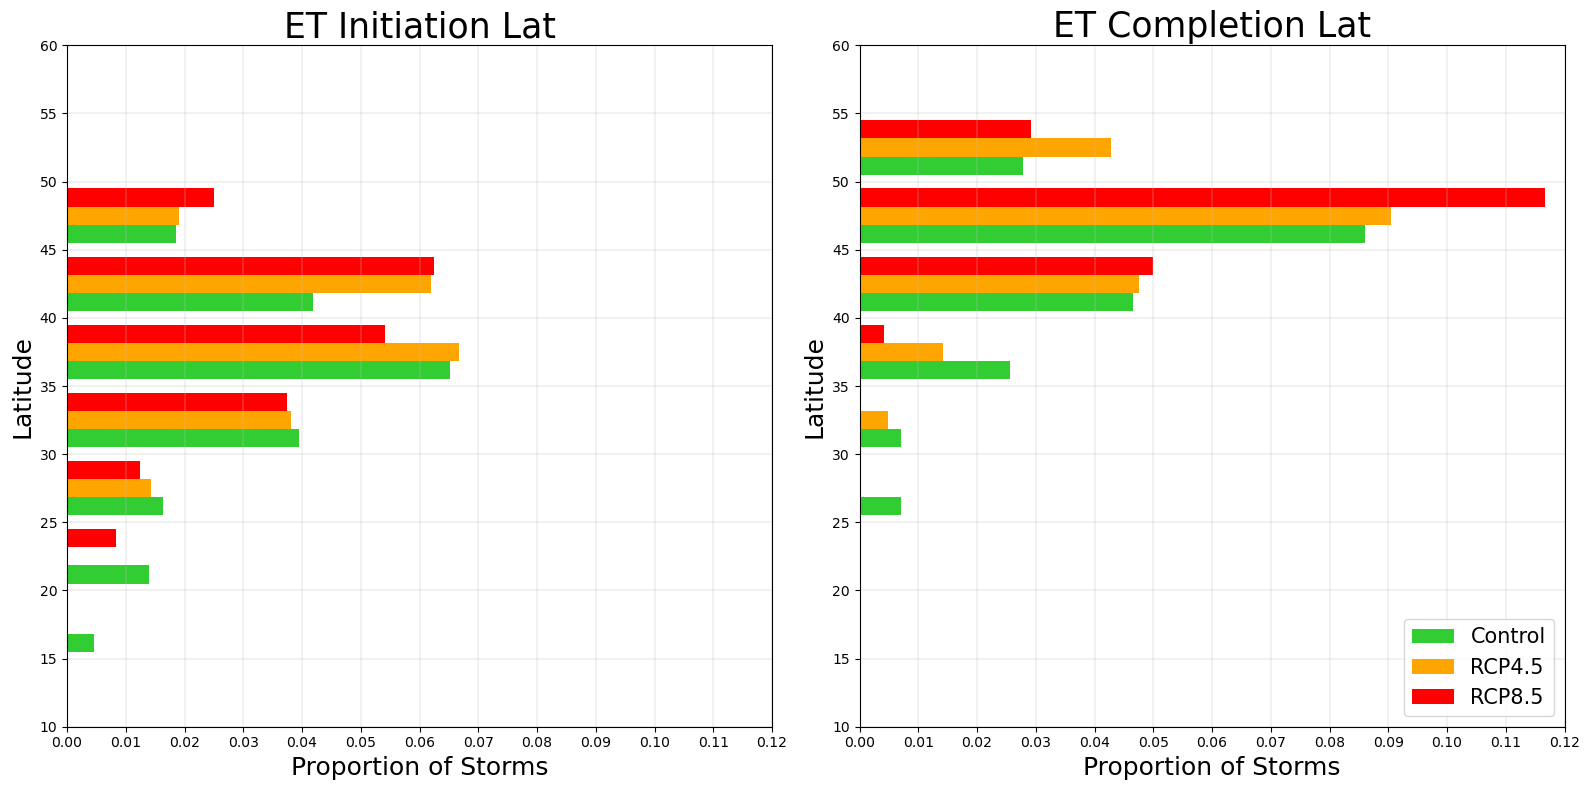

In [58]:
# ET Initiation and Completion Latitude (Relative)
Var = "Lat"
Var_Label = "Latitude"
Rela = True
Orient = 'horizontal'
Bins = Lat_Bins
Dens_Min, Dens_Max, Dens_Width = 0, 0.12, 0.01
Savefig = True
Figname = 'ET_Latitude_Histo_Rela.png'
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

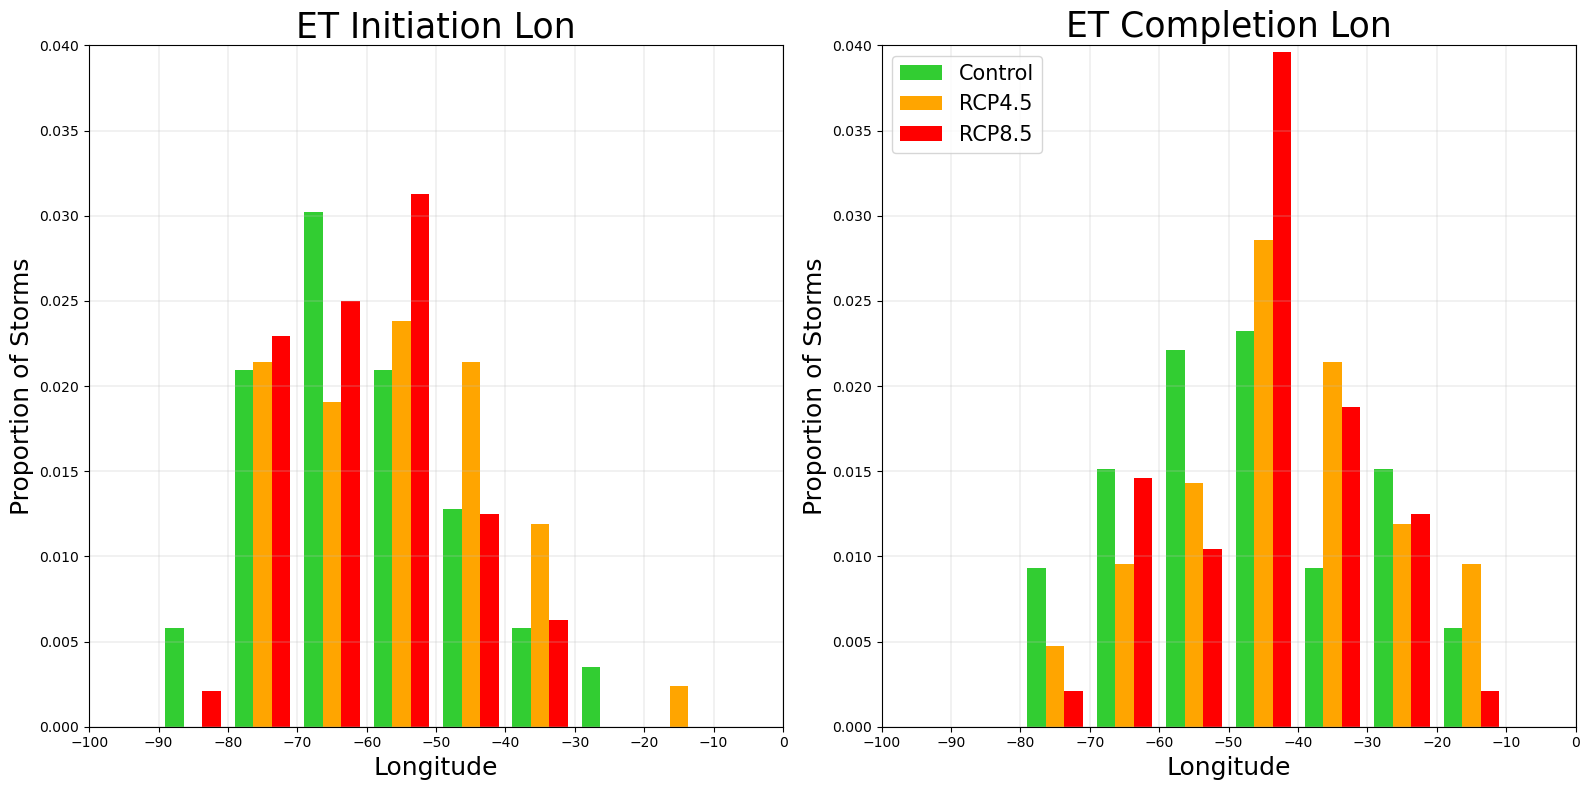

In [61]:
# ET Initiation and Completion Longitude (Relative)
Var = "Lon"
Var_Label = "Longitude"
Rela = True
Orient = 'vertical'
Bins = Lon_Bins
Dens_Min, Dens_Max, Dens_Width = 0, 0.04, 0.005
Savefig = True
Figname = 'ET_Longitude_Histo_Rela.png'
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

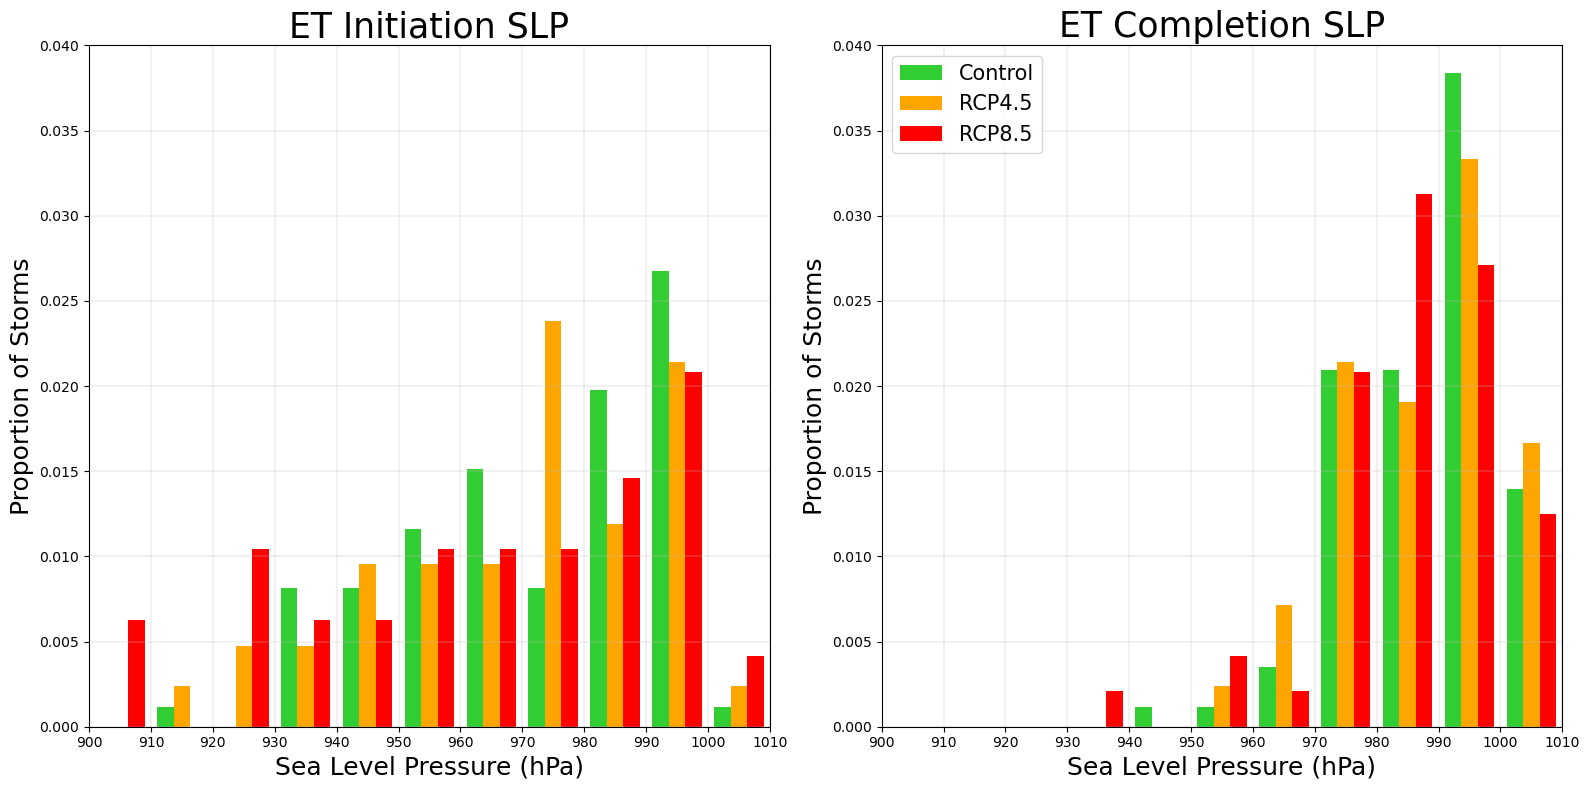

In [44]:
# ET Initiation and Completion SLP (Relative)
Var = "SLP"
Var_Label = "Sea Level Pressure (hPa)"
Rela = True
Orient = 'vertical'
Bins = SLP_Bins
Dens_Min, Dens_Max, Dens_Width = 0, 0.04, 0.005
Savefig = True
Figname = 'ET_SLP_Histo_Rela.png'
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

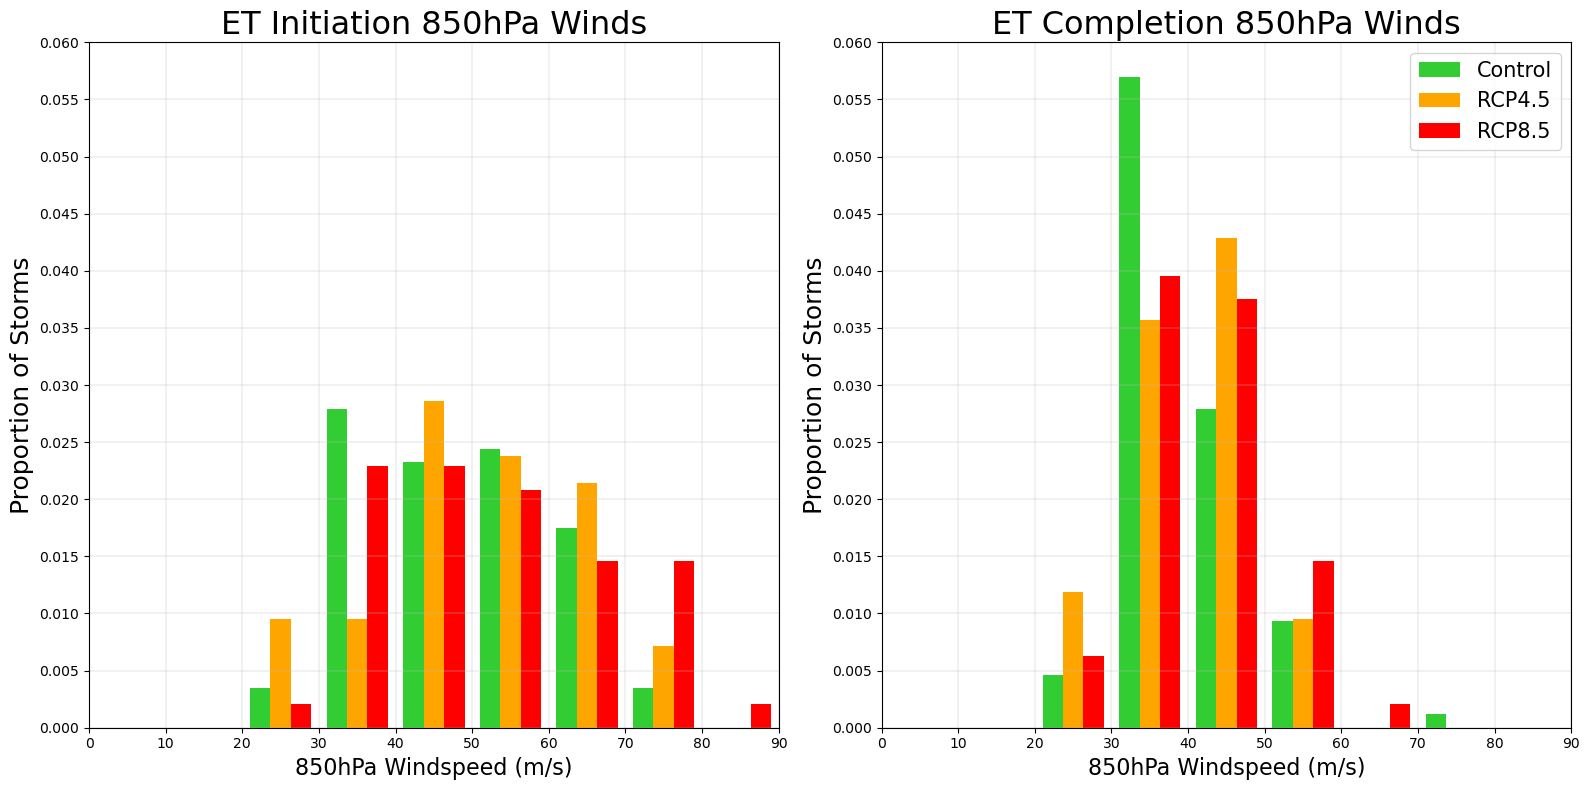

In [116]:
Var = "850hPa Winds"
Var_Title = "850hPa Winds"
Var_Label = "850hPa Windspeed (m/s)"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,90,10)
Dens_Min, Dens_Max, Dens_Width = 0, 0.06, 0.005
Savefig = True
Figname = 'ET_850hPa_Winds_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

#ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, \
#"850hPa Winds", True, 'horizontal', Create_Bins(0,90,10), True, 'ET_850hPa_Winds_Histo.png')

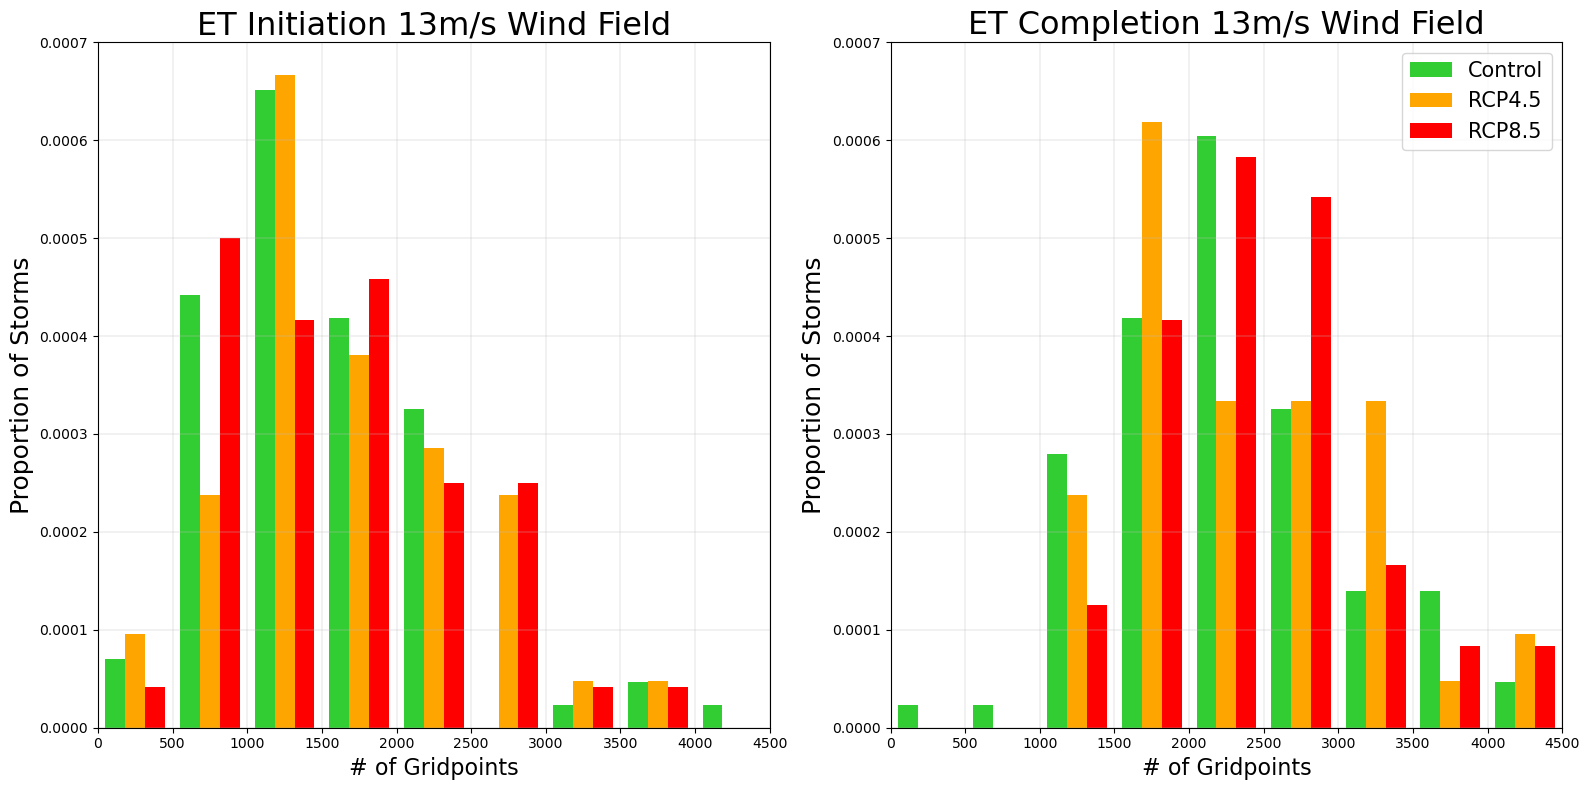

In [92]:
Var = "13m/s"
Var_Title = "13m/s Wind Field"
Var_Label = "# of Gridpoints"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,4500,500)
Dens_Min, Dens_Max, Dens_Width = 0, 0.0007, 0.0001
Savefig = True
Figname = 'ET_Wind_13ms_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

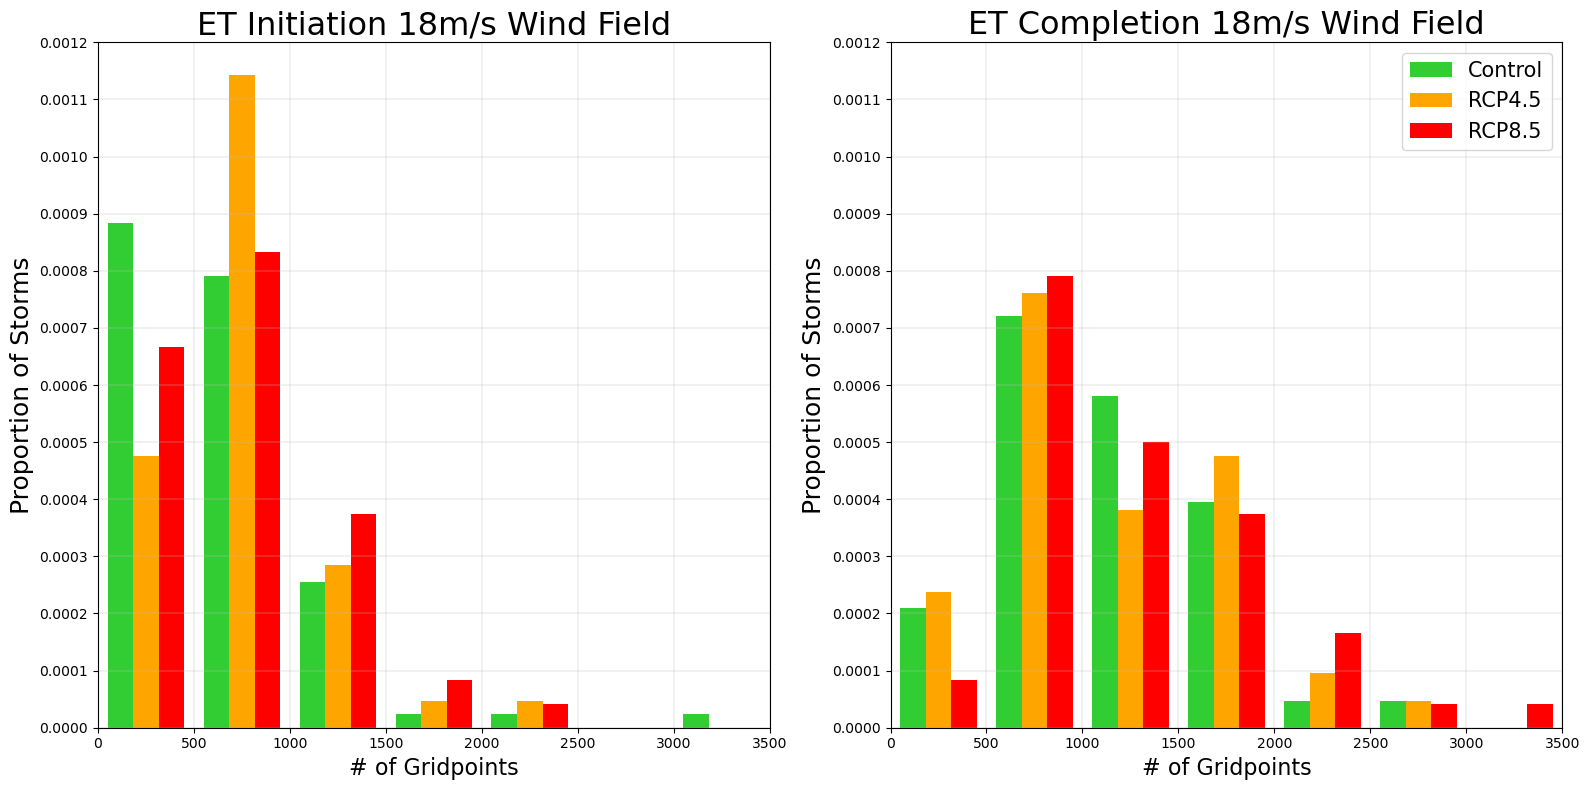

In [90]:
Var = "18m/s"
Var_Title = "18m/s Wind Field"
Var_Label = "# of Gridpoints"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,3500,500)
Dens_Min, Dens_Max, Dens_Width = 0, 0.0012, 0.0001
Savefig = True
Figname = 'ET_Wind_18ms_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

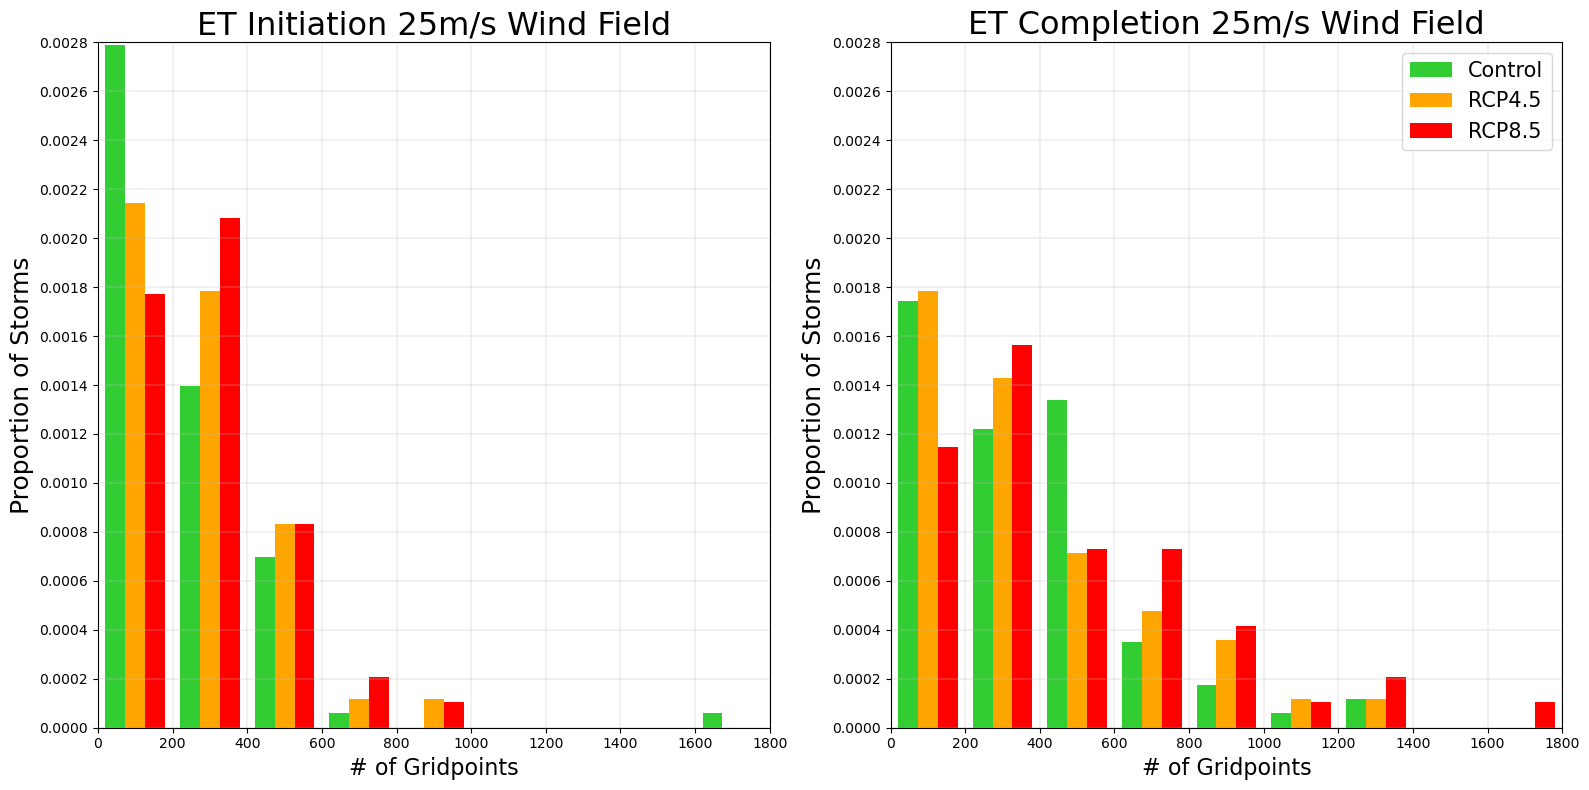

In [121]:
Var = "25m/s"
Var_Title = "25m/s Wind Field"
Var_Label = "# of Gridpoints"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,1800,200)
Dens_Min, Dens_Max, Dens_Width = 0, 0.0028, 0.0002
Savefig = True
Figname = 'ET_Wind_25ms_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

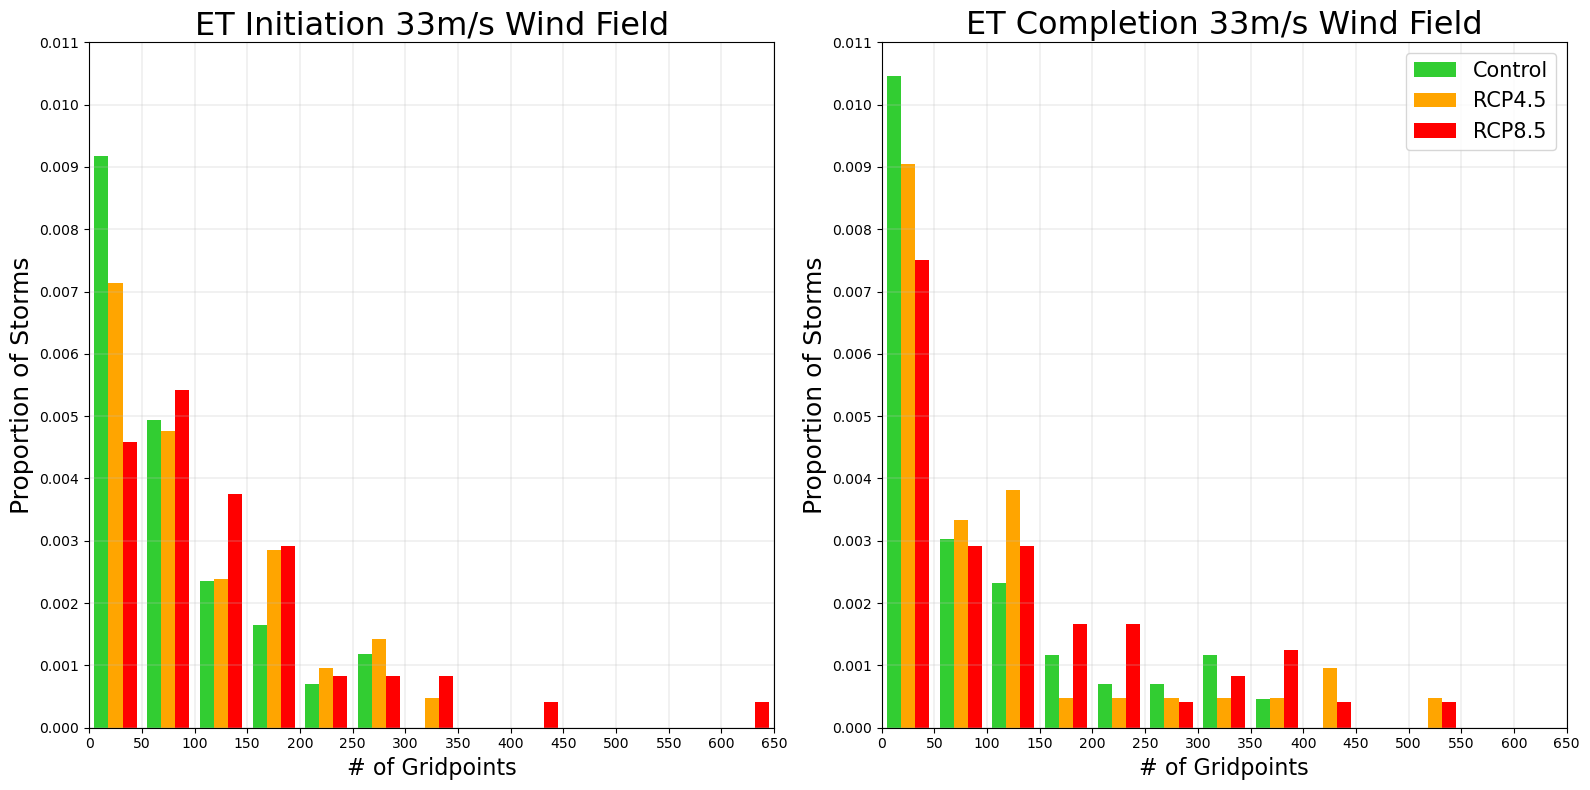

In [94]:
Var = "33m/s"
Var_Title = "33m/s Wind Field"
Var_Label = "# of Gridpoints"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,650,50)
Dens_Min, Dens_Max, Dens_Width = 0, 0.011, 0.001
Savefig = True
Figname = 'ET_Wind_33ms_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

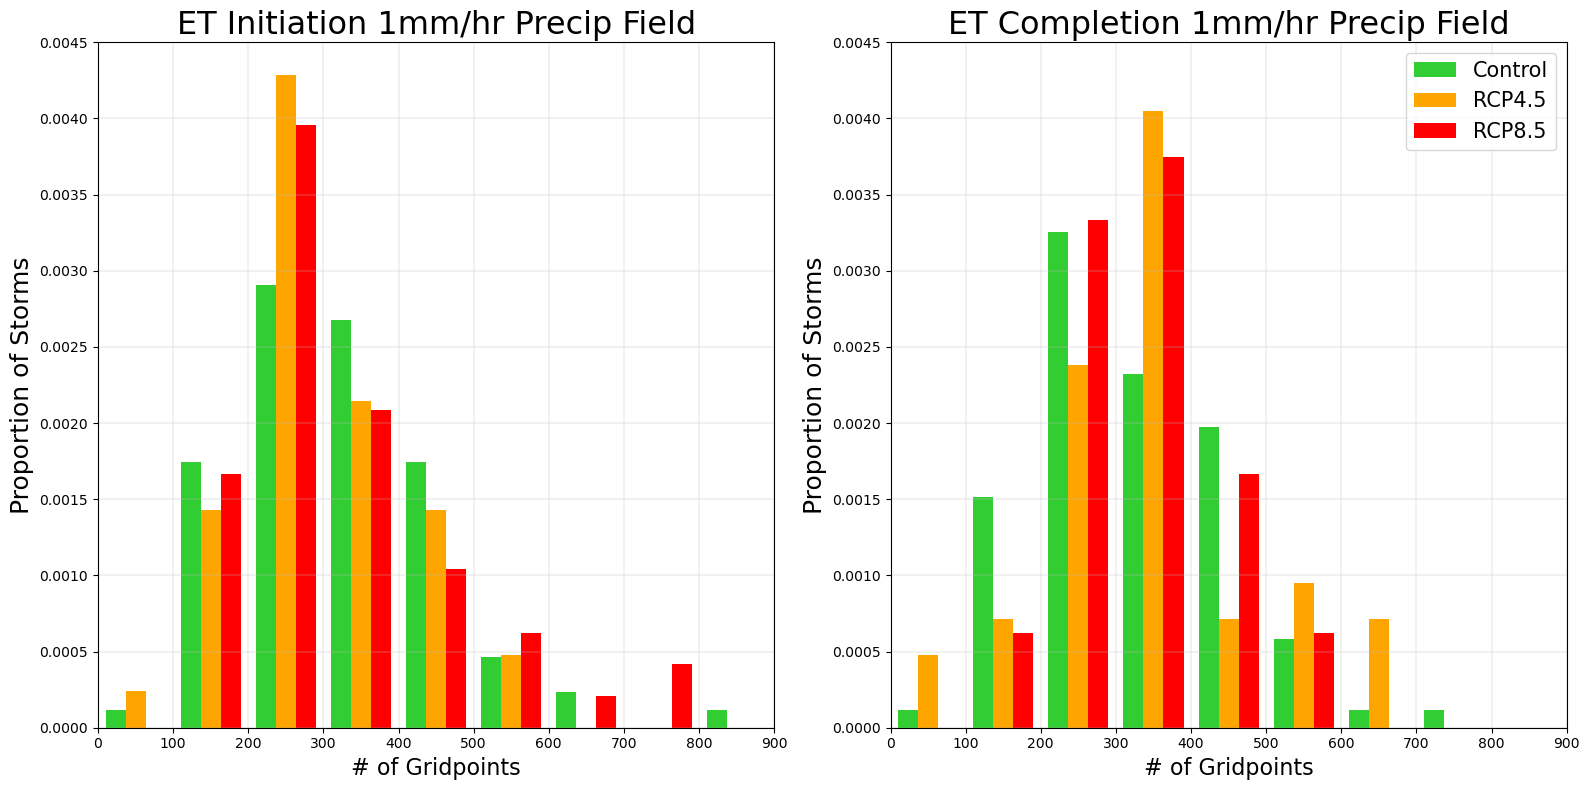

In [95]:
Var = "1mm/hr"
Var_Title = "1mm/hr Precip Field"
Var_Label = "# of Gridpoints"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,900,100)
Dens_Min, Dens_Max, Dens_Width = 0, 0.0045, 0.0005
Savefig = True
Figname = 'ET_Precip_1mmhr_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

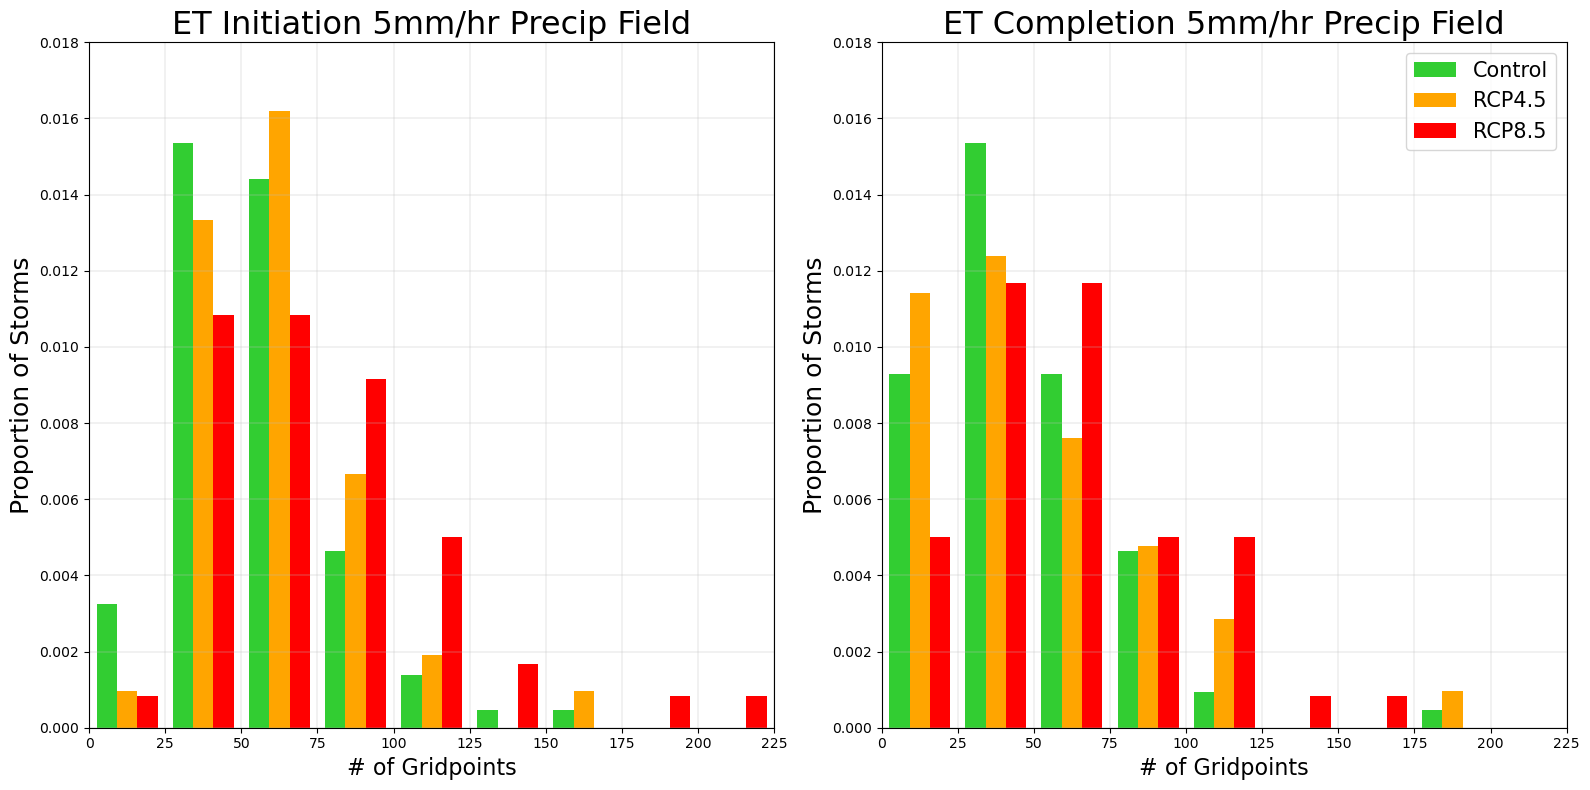

In [97]:
Var = "5mm/hr"
Var_Title = "5mm/hr Precip Field"
Var_Label = "# of Gridpoints"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,225,25)
Dens_Min, Dens_Max, Dens_Width = 0, 0.018, 0.002
Savefig = True
Figname = 'ET_Precip_5mmhr_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

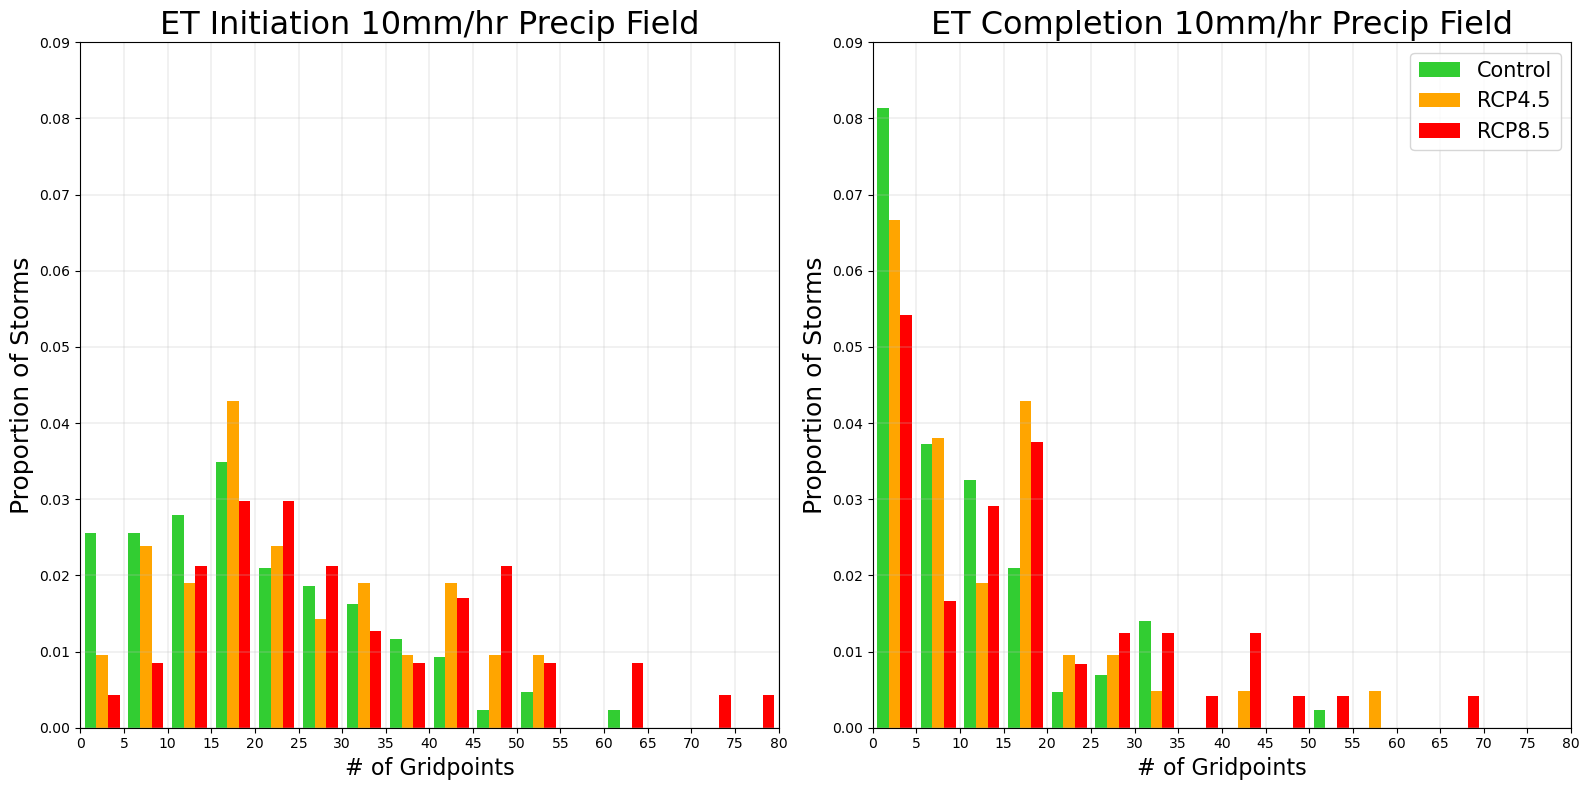

In [103]:
Var = "10mm/hr"
Var_Title = "10mm/hr Precip Field"
Var_Label = "# of Gridpoints"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,80,5)
Dens_Min, Dens_Max, Dens_Width = 0, 0.09, 0.01
Savefig = True
Figname = 'ET_Precip_10mmhr_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

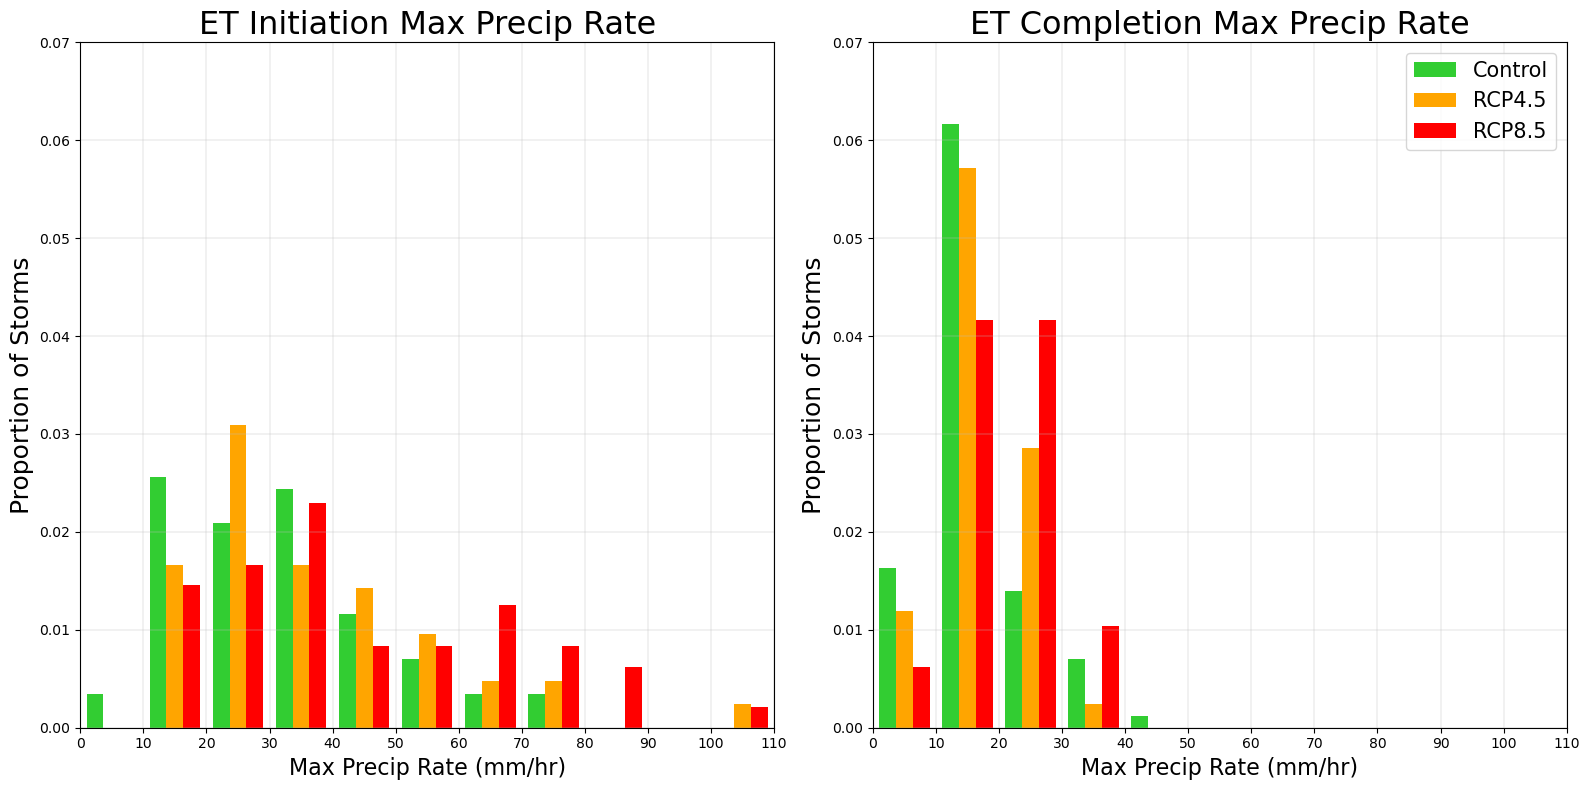

In [107]:
Var = "Max Precip Rate"
Var_Title = "Max Precip Rate"
Var_Label = "Max Precip Rate (mm/hr)"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,110,10)
Dens_Min, Dens_Max, Dens_Width = 0, 0.07, 0.01
Savefig = True
Figname = 'ET_Max_Precip_Rate_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

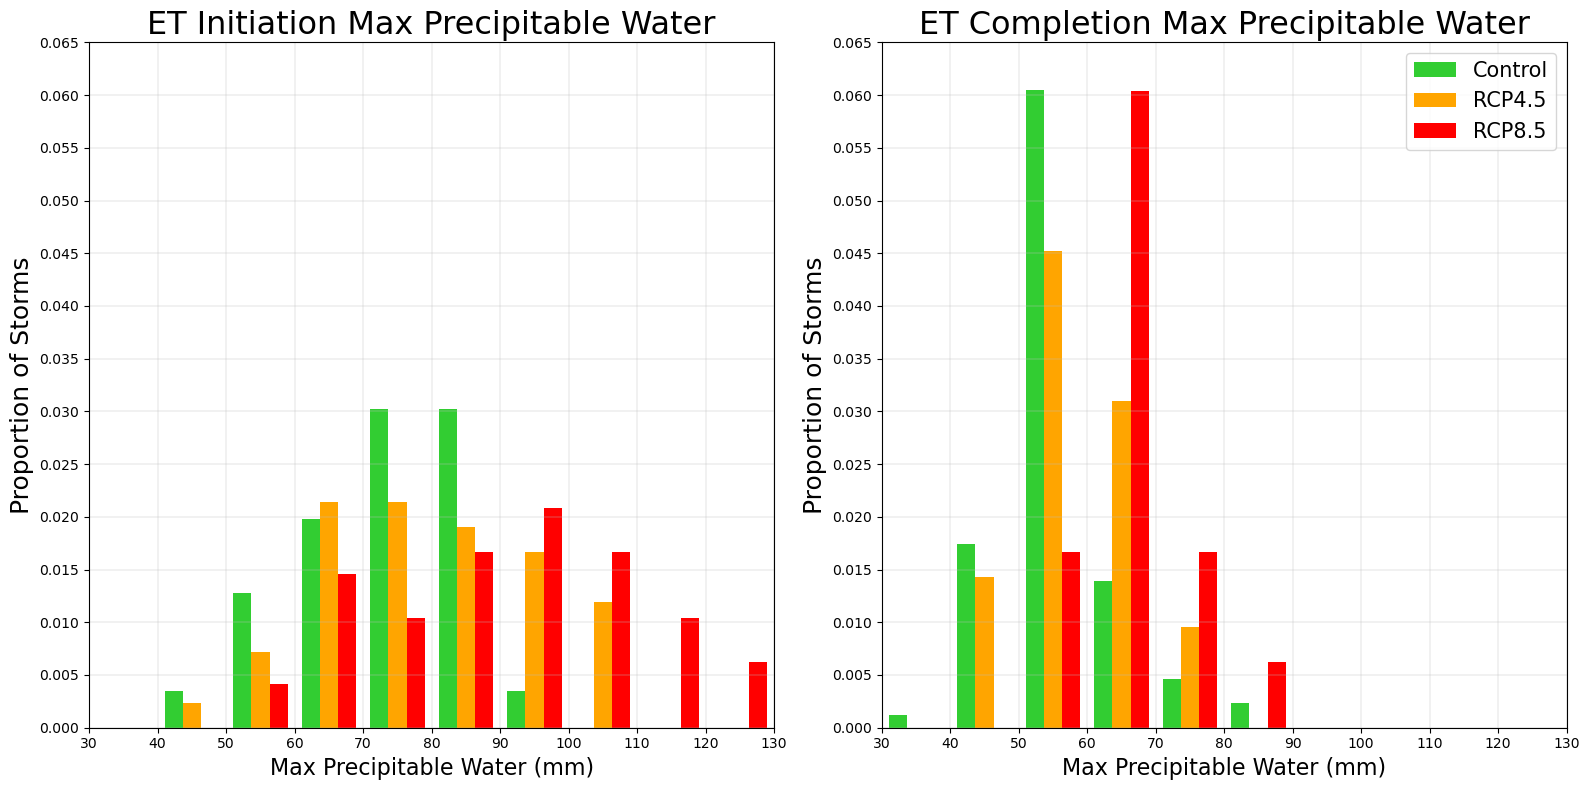

In [122]:
Var = "Max Precip Water"
Var_Title = "Max Precipitable Water"
Var_Label = "Max Precipitable Water (mm)"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(30,130,10)
Dens_Min, Dens_Max, Dens_Width = 0, 0.065, 0.005
Savefig = True
Figname = 'ET_Max_Precip_Water_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

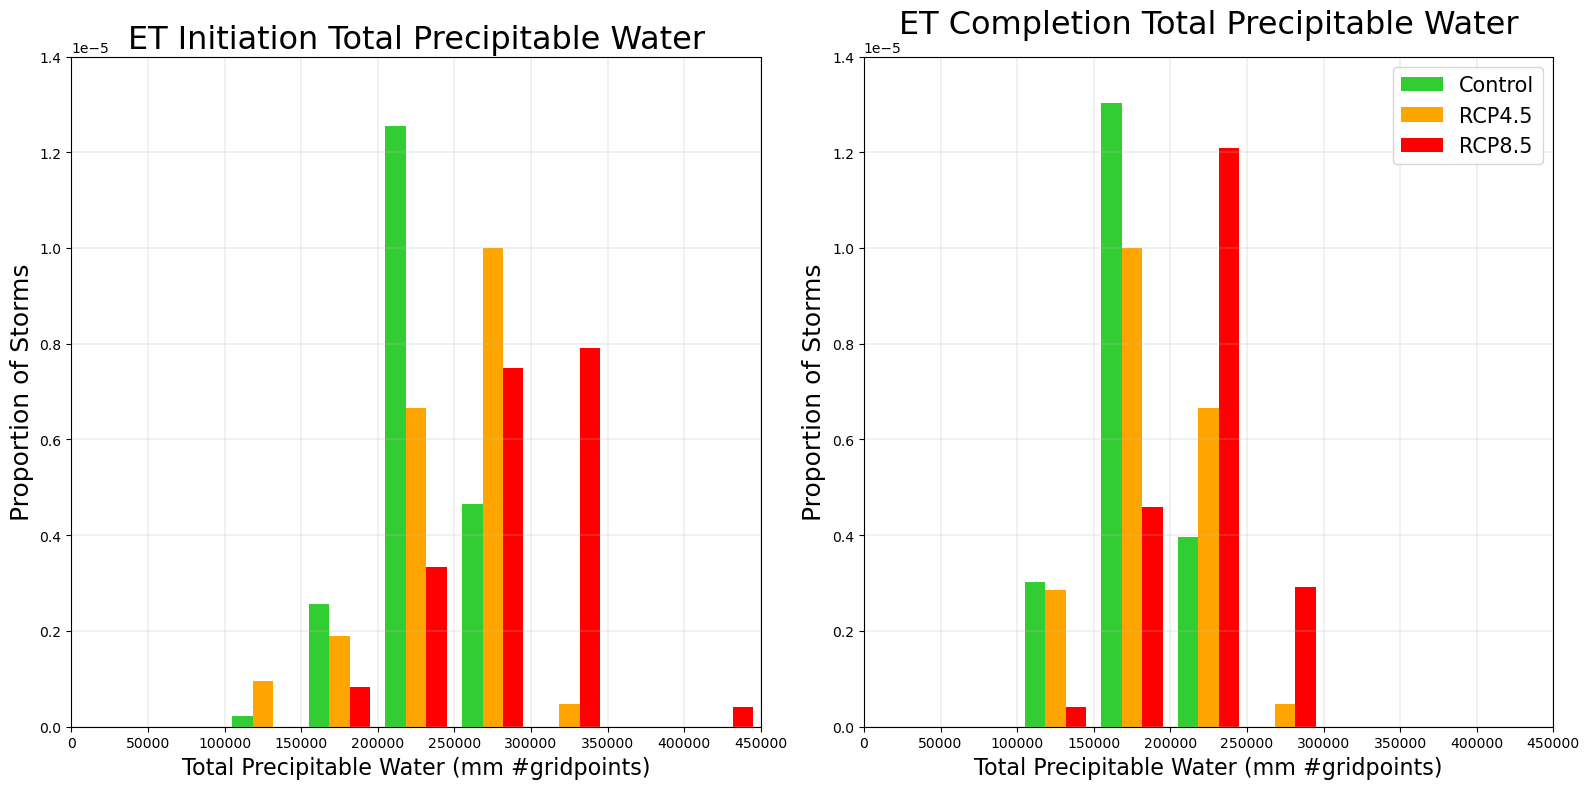

In [128]:
Var = "Total Precip Water"
Var_Title = "Total Precipitable Water"
Var_Label = "Total Precipitable Water (mm #gridpoints)"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0,450000,50000)
Dens_Min, Dens_Max, Dens_Width = 0, 0.000014, 0.000002
Savefig = True
Figname = 'ET_Total_Precip_Water_Histo.png'
ET_Compo_Histogram(Control_ET_Compo, RCP45_ET_Compo, RCP85_ET_Compo, Var, Var_Title, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)